## 学习神经网络

* 查阅scikit-learn工具包中前馈神经网络学习器的相关说明，了解相关函数使用方法。
* 基于NumPy设计一个包含输入层、隐含层和多分类输出层的前馈神经网络，并以此为基础对手写数字图像进行分类实验。（交电子版实验报告）

有余力实现输入输出规模适应

# sklearn前馈神经网络

## 加载数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.latex.repr = False
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape,digits.target.shape)

(1797, 64) (1797,)


## 训练集、验证集、测试集分割

使用`train_test_split`对训练集、测试集进行分割，使20%数据进入测试集。用Y值设定`stratify`参数，保证训练集、测试集类别分布一致。

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size = 0.2, random_state = 512, stratify = digits.target)

使用K折交叉验证分割训练集和验证集。

In [3]:
from sklearn.model_selection import StratifiedKFold
N=5
skf = StratifiedKFold(n_splits=N,random_state=256,shuffle=True)

## 模型加载

`sklearn`的`neural_network`包有多层感知机分类模型`MLPClassifier()`，搭建baseline：

In [4]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.9722222222222222

## 模型优化

由于选择的是小手写数据集，每条记录仅由64维0-1数据构成，默认参数下模型就能有较好表现。查阅`sklearn`参数后，发现多层感知机有多个参数可以调节：
```Python
class sklearn.neural_network.MLPClassifier(hidden_layer_sizes=100, activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
```

* `hidden_layer_sizes`: 隐层规模，可以传入多维数组，第i维数值代表第i层隐层的神经元数量。这个参数可以直观调整网络结构。
* `activation`：激活函数，可取`identity`（$f(x)=x$）、`logistic`（$f(x)=\dfrac{1}{1+e^{-x}}$）、`tanh`（$f(x)=\tanh{(x)}$）、`relu`（$f(x)=\max(0,x)$）
* `solver`：权值优化器，默认`adam`在大数据集上表现很好，小数据集其实可以改为`lbfgs`提升速度。
* `learning_rate_init`：初始学习率，默认为0.001
* `learning_rate`：学习率更新方式：`constant`不变，`invscaling`使学习率按轮数t衰减，由参数`power_t`控制： $lr_{t}= \dfrac{lr_{\text{init}}}{t^\text{power_t}}$，`adaptive`若连续两轮损失函数减少值/验证集准确率增加值少于`tol`则当前准确率除以5，否则保持不变。

…………

因为数据集规模小，后续`solver`都采用`lbfgs`，调节其他参数。先尝试调节学习率：

In [5]:
ts = 0; vs = 0;
for train_idx, val_idx in skf.split(X_train,y_train):
    clf = MLPClassifier(solver='lbfgs',learning_rate_init=0.01,learning_rate='adaptive')
    clf.fit(X_train[train_idx], y_train[train_idx])
    ts += clf.score(X_train[train_idx],y_train[train_idx])
    vs += clf.score(X_train[val_idx],y_train[val_idx])
print('Training Score: %.3f' % float(ts/N))
print('Validation Score: %.3f' % float(vs/N))

Training Score: 1.000
Validation Score: 0.974


设定初始参数为不同数量级（$10^{-1}$ ~ $10^{-7}$）,最终验证集准确率均在0.96~0.97水平之间。可能这是因为数据复杂度不高，学习率的影响不大。

尝试调节网络结构：

In [6]:
ts = 0; vs = 0;
for train_idx, val_idx in skf.split(X_train,y_train):
    clf = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(16,16))
    clf.fit(X_train[train_idx], y_train[train_idx])
    ts += clf.score(X_train[train_idx],y_train[train_idx])
    vs += clf.score(X_train[val_idx],y_train[val_idx])
print('Training Score: %.3f' % float(ts/N))
print('Validation Score: %.3f' % float(vs/N))

Training Score: 1.000
Validation Score: 0.945


当调整隐层神经元数量为较小值时，准确率会出现明显的下降，甚至有的迭代过程中会导致函数出现无法收敛的报错。

当调整隐层神经元数量小于分类数时，这时的模型已经非常不合理，通过少于分类数的运算，输出层无法得出所有可能输出，准确率出现明显的下降。

In [7]:
ts = 0; vs = 0;
for train_idx, val_idx in skf.split(X_train,y_train):
    clf = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(200,100))
    clf.fit(X_train[train_idx], y_train[train_idx])
    ts += clf.score(X_train[train_idx],y_train[train_idx])
    vs += clf.score(X_train[val_idx],y_train[val_idx])
print('Training Score: %.3f' % float(ts/N))
print('Validation Score: %.3f' % float(vs/N))

Training Score: 1.000
Validation Score: 0.973


当调整隐层神经元数量至较大值或者随意地增加隐层数目，会增加模型复杂度，导致运算时间增大，而准确率提升不明显。

所以，隐层参数应根据问题进行合理调整，并且一般后面的隐层神经元数量要小于等于上一隐层。

# 神经网络实现-基于Numpy

## 神经元结构确定

### 基本结构：权重、偏置、输入输出
首先，观察一个神经元的结构：

![](https://downloads.mariozzj.cn/img/picgo/图片1.png?imageMogr2/thumbnail/!50p)


在一个前馈神经网络中，一个神经元需要接受上一层的所有神经元的输出$\boldsymbol{x}^{(l-1)}=(x_1^{(l-1)},x_2^{(l-1)},\cdots,x_n^{(l-1)})$，乘上权重$\boldsymbol{w}^{(l)}=(w_1^{(l-1)},w_2^{(l-1)},\cdots,w_n^{(l-1)})$加上偏置$b^{(l)}_i$作为输入$\alpha_i^{(l)}=\boldsymbol{w}_i^{(l)}\cdot \boldsymbol{x}_i^{(l-1)}+b^{(l)}_i$，而本层将输入用激活函数$\sigma(\alpha_i^{(l)})$进行计算，得到输出$x_i^{(l)}=\sigma(\boldsymbol{\alpha})$。

所以，对于一层的神经元而言，需要的基础变量是上一层的输入对应的权重$\boldsymbol{w}^{(l)}$、偏置$\boldsymbol{b}^{(l)}$，以及指定的激活函数。在训练过程中，需要对$\boldsymbol{w}^{(l)}$、$\boldsymbol{b}^{(l)}$进行更新:

$$
 w \leftarrow w-\eta \dfrac{\partial\mathcal{L}}{\partial w} \\
 b \leftarrow b-\eta \dfrac{\partial\mathcal{L}}{\partial b} 
$$

其中$\mathcal{L}$是损失函数，$\eta$为学习率。

In [8]:
class Layer:
    def __init__(self, size, prevsize):
        self.w = np.random.randn(prevsize,size)
        self.b = np.random.randn(size,1)
        self.alpha = np.zeros((size,1))
        self.x = np.zeros((size,1))

### 损失函数

由于参数的更新涉及到求导，损失函数可以选用易于求导的函数，对训练例$(\boldsymbol{x}_k,\boldsymbol{y}_k)$，设输出层输出为$\hat{y}_j^k(j=1,2,\cdots,l)$，目标输出为$\boldsymbol{y}_k=(y_1^k,y_2^k,\cdots,y_l^k)$，损失函数可采用交叉熵损失函数

$$
\mathcal{L}(\boldsymbol{y}_k,\boldsymbol{\hat{y}}_k)=\sum\limits_{j=1}^l y_j^k\log\hat{y}_j^k
$$

其偏微分是易求的，例如对输出层第m个输出$\hat{y}_m^k$的偏微分$\dfrac{\partial\mathcal{L}}{\partial \hat{y}_m^k}=\dfrac{y_m^k}{\hat{y}_m^k}$

In [9]:
def crossEntropy(y,y_pred):
    return -np.sum(y.T*np.log(y_pred+1e-16)) #y_pred加上一个"无穷小量"，防止出现对数为0.

### 激活函数

由于参数的更新涉及到求导，为简化这一过程的实现，隐藏层的激活函数可以采用Logistic函数$\sigma(x) = \dfrac{1}{1+e^{-x}}$，因为这一函数的导数具有容易计算的优秀性质：$\sigma'(x)=\sigma(x)(1-\sigma(x))$。也可以采用Relu函数$\text{Relu}(x)=\max(0,x)$，导数为$\text{Relu}'(x)=\left\{ \begin{align}1,\ &x\ge 0\\ 0, \ &x\lt 0\end{align}\right.$

而输出层的激活函数可以根据任务而定，本任务为手写数字分类，为多分类任务，可以使用Softmax函数。

Softmax函数的求导较为复杂，通过阅读[@永远在你身后 的博文](https://zhuanlan.zhihu.com/p/67759205)，发现在本次应用中可以将其简化，这篇文章的推导最终指出，使用交叉熵作为多分类计算的损失函数时，
$$
\dfrac{\partial \mathcal{L}}{\partial \alpha_i^{(\text{output})}}=\text{Softmax}\left(\alpha_i^{(\text{output})}\right)-y_i
$$

其中，$y_i$为0或1，为1时为正确样本分类。

即不体现计算$\dfrac{\partial \mathcal{L}}{\partial x_i^{(\text{output})}}\dfrac{\partial x_i^{(\text{output})}}{\partial \alpha_i^{(\text{output})}}$ 而是直接计算 $\dfrac{\partial \mathcal{L}}{\partial \alpha_i^{(\text{output})}}$。

输入层不需要激活函数（identity即可）。

In [10]:
class sigmoid:
    def __init__(self):
        pass
    def func(self,X):
        return 1.0/(1+np.exp(-X))
    def deriv(self,X):
        return self.func(X)*(1-self.func(X))

class relu:
    def __init__(self):
        pass
    def func(self,X):
        return np.maximum(0,X)
    def deriv(self,X):
        return 1*(X >= 0)

class softmax:
    def __init__(self):pass
    def func(self,X):
        return np.exp(X-X.max())/np.sum(np.exp(X-X.max()))
    # 统一减去最大值可以保证不出现溢出，同时因为存在归一化所以结果不变
    # 仅用于输出层，不可调整，故不定义导数
    
class identity:
    def __init__(self):pass
    def func(self,X): return X
    def deriv(self,X): return 1

### 参数更新：基于反向传播

损失函数我们只有在输出层通过计算得到，所以要想实现对参数的更新，要先通过参数计算前向传播到输出层得到损失，再反向传播求偏导更新各层参数。
![](https://downloads.mariozzj.cn/img/picgo/图片4.png)




由$\alpha_i^{(l)}=\sum\limits_{j=1}^{N_{l-1}} w_{ji}^{(l)}x_j^{(l-1)}+b_i^{(l)}$知$\dfrac{\partial \alpha_i^{(l)}}{\partial x_j^{(l-1)}}=w_{ji}^{(l)}$，$\dfrac{\partial \alpha_i^{(l)}}{\partial w_{ji}^{(l)}}=x_{j}^{(l-1)}$，$\dfrac{\partial \alpha_i^{(l)}}{\partial b}=1$。

由$x_i^{(l)}=\sigma(\alpha_i^{(l)})$知$\dfrac{\partial x_i^{(l)}}{\partial \alpha_i^{(l)}}=\sigma'(\alpha_i^{(l)})=\sigma(\alpha_i^{(l)})\times\sigma(1-\alpha_i^{(l)})$。

所以，结合上图，要实现对参数的更新，需要从输出层开始迭代计算才能得到。则更新参数：

$$
\begin{align}
w_{ij}^{(l)} &= w_{ij}^{(l)} - \eta\dfrac{\partial \mathcal{L}}{\partial w_{ij}^{(l)}}\\
&= w_{ij}^{(l)} - \eta\sum\limits_{m}^{N_L}\dfrac{\partial \mathcal{L}}{\partial \hat{y}_m}\dfrac{\partial \hat{y}_m}{\partial \alpha_m^{(L)}}\left(\sum\limits_{m}^{N_{L}}\sum\limits_{p}^{N_{L-1}}\dfrac{\partial \alpha_m^{(L)}}{\partial x_p^{(L-1)}}\dfrac{\partial x_p^{(L-1)}}{\partial \alpha_p^{(L-1)}}\cdots\sum\limits_{q}^{N_{l+1}}\sum\limits_{r}^{N_{l}}\dfrac{\partial \alpha_q^{(l+1)}}{\partial x_r^{(l)}}\dfrac{\partial x_r^{(l)}}{\partial \alpha_r^{(l)}}\cdot\dfrac{\partial \alpha_r^{(l)}}{\partial w_{ij}^{(l)}}\right)\\
b_{j}^{(l)} &= b_{j}^{(l)} - \eta\dfrac{\partial \mathcal{L}}{\partial b_{j}^{(l)}}\\
&= b_{j}^{(l)} - \eta\sum\limits_{m}^{N_L}\dfrac{\partial \mathcal{L}}{\partial \hat{y}_m}\dfrac{\partial \hat{y}_m}{\partial \alpha_m^{(L)}}\left(\sum\limits_{m}^{N_{L}}\sum\limits_{p}^{N_{L-1}}\dfrac{\partial \alpha_m^{(L)}}{\partial x_p^{(L-1)}}\dfrac{\partial x_p^{(L-1)}}{\partial \alpha_p^{(L-1)}}\cdots\sum\limits_{q}^{N_{l+1}}\sum\limits_{r}^{N_{l}}\dfrac{\partial \alpha_q^{(l+1)}}{\partial x_r^{(l)}}\dfrac{\partial x_r^{(l)}}{\partial \alpha_r^{(l)}}\cdot\dfrac{\partial \alpha_r^{(l)}}{\partial b_{j}^{(l)}}\right)
\end{align}
$$
实际上，要更新某一层网络的参数，需要首先算出的是损失函数对当前神经元输入的偏微分$\dfrac{\partial \mathcal{L}}{\partial \alpha_i^{(l)}}$，再分别求输入对$w$、$b$的偏微分。而算出$\dfrac{\partial \mathcal{L}}{\partial \alpha_i^{(l)}}$实际上依赖于下一层的梯度$\dfrac{\partial \mathcal{L}}{\partial \alpha_j^{(l+1)}}(j=1,2,\cdots.N_{l+1})$，以此类推，所以还需要一个属性用于存储该梯度，便于反向运算。


### 层结构确定

* 基本结构：
    * 权重矩阵`w`，规模为上层神经元数量×本层神经元数量。还要加上一个旧$w$的存储。
    * 偏置向量`b`，规模为本层神经元数量×1。
    * 本层输入向量`x`：规模为本层神经元数量×1。
    * 本层输出向量$\alpha$：规模为本层神经元数量×1。
    * 梯度向量：存储$\dfrac{\partial \mathcal{L}}{\partial \alpha_i^{(l)}}$值，规模为本层神经元数量×1。
    * 损失函数
    * 指向上一层（前向传播和反向传播求$w$导数时用到了上一层的$x$）、下一层（反向传播用到了后层的梯度和$w$）的指针。

* 方法：
    * 初始化：随机指定$w$、$b$
    * `forward()`实现前向传播
        * 根据上层输出计算本层输入$\alpha_i^{(l)}=\sum\limits_{j=1}^{N_{l-1}}w_{ji}^{(l)}x_j^{(l-1)} + b_i^{(l)}$
        * 使用激活函数算出本层输出$x_i^{(l)}=\sigma(\alpha_i^{(l)})$
        * 递归调用后一层的`forward()`
    * `backPropagation()`实现反向传播
        * 计算本层梯度$\dfrac{\partial \mathcal{L}}{\partial \alpha_i^{(l)}}=\sigma'(\alpha_i^{(l)})\cdot\left(\sum\limits_{j=1}^{N_{l-1}}\dfrac{\partial \mathcal{L}}{\partial \alpha_j^{(l+1)}}w_{ij}^{(l+1)}\right)$。
        * 更新参数$w_{ij}^{(l)}=w_{ij}^{(l)}-\eta\dfrac{\partial \mathcal{L}}{\partial \alpha_i^{(l)}}\cdot x_i^{(l)}$；$b_{i}^{(l)}=b_{i}^{(l)}-\eta\dfrac{\partial \mathcal{L}}{\partial \alpha_i^{(l)}}\cdot1$
        * 递归调用前一层的BP.
    
* 继承：
    * 设定隐层为基类`Layer`，输入层和输出层集成基类，重写方法。更改指定的激活函数。
    * 输出层`outputLayer`：
        * 追加属性`y`，存储目标值
        * 追加计算损失函数的方法`calcLoss()`;
        * 重写BP方法，修改梯度的计算方法为$\dfrac{\partial \mathcal{L}}{\partial \alpha_i^{(\text{output})}}=\text{Softmax}\left(\alpha_i^{(\text{output})}\right)-y_i$;
        * 重写forward方法，不再递归调用forward。
    * 输入层`inputLayer`：
        * 重写forward方法，要求传入x直接为输出，不计算w、b。
        * 重写BP方法，不进行计算，不递归调用。

In [11]:
class Layer:
    lr = 0.001
    def __init__(self, size, prevsize, activation_func=sigmoid()):
        self.w = np.random.randn(prevsize,size)
        self.b = np.random.randn(size,1)
        self.alpha = np.zeros((size,1))
        self.x = np.zeros((size,1))
        self.w_old = self.w.copy()
        self.grad = np.zeros((size,1))
        self.act_func = activation_func
        self.prevLayer = None
        self.nextLayer = None
        
    def forward(self):
        self.alpha = np.sum(self.prevLayer.x* self.w.T ,axis=1)
        self.x = self.act_func.func(self.alpha)
        self.w_old = self.w.copy()
        self.nextLayer.forward()
    
    def backPropagation(self):
        self.grad = np.sum(self.nextLayer.grad*self.nextLayer.w_old,axis=1)*self.act_func.deriv(self.alpha)
        self.w = np.array(self.w - Layer.lr*np.mat(self.prevLayer.x).T*np.mat(self.grad))
        self.b = self.w - Layer.lr*self.grad
        self.prevLayer.backPropagation()

In [12]:
class outputLayer(Layer):
    def __init__(self, size, prevsize, activation_func=softmax(), loss_func=crossEntropy):
        super(outputLayer, self).__init__(size, prevsize,activation_func)
        self.y = np.zeros((size,1))
        self.loss_func = crossEntropy
        
    def calcLoss(self):
        return self.loss_func(self.y,self.x)
    
    def forward(self):
        self.alpha = np.sum(self.prevLayer.x* self.w.T ,axis=1)
        self.x = self.act_func.func(self.alpha)
        self.w_old = self.w.copy()
    
    def backPropagation(self):
        self.grad = self.act_func.func(self.alpha) - self.y
        self.w = np.array(self.w - Layer.lr*np.mat(self.prevLayer.x).T*np.mat(self.grad))
        self.b = self.b - Layer.lr*self.grad
        self.prevLayer.backPropagation()

In [13]:
class inputLayer(Layer):
    def __init__(self, size, activation_func=identity()):
        super(inputLayer, self).__init__(size, 1, activation_func)
    
    def forward(self,X):
        self.x = self.act_func.func(X)
        self.nextLayer.forward()
    
    def backPropagation(self):
        pass

## 神经网络实现

因为上一节中体验了`sklearn`的神经网络分类器，因此部分功能的实现和方法也尽量仿照其功能来写，沿用部分属性名。

### 初始化

注意到`sklearn`的初始化并未传入训练数据，且不指定输入输出层参数（实际上与数据有关），判定此时实际上没有初始化，仅进行参数存储，因此`__init__()`方法也只存参数。

### 训练

网络的初始化实际从这里开始，根据输入输出特征（自适应）调整输入层、输出层结构，根据参数调整隐层结构。

当网络各层构建完成时，更新网络属性中的前后层指针。

开始迭代训练（调用第一层forward和最后一层BP），设置终止条件：①迭代次数到限制；②参数变化小于阈值。

记录训练过程（损失值、准确率）

### 测试

仅调用第一层forward，输入数据，计算损失值、准确率并返回。

### 预测

由于原数据值不是onehot而是一列向量，所以返回的应该是经过argmax处理的结果。同样是调用forward计算到最后一层，再保存所有结果。

### 实现

In [14]:
class BPNeuralNetwork:
    def __init__(self,hidden_layer_sizes=100,activation=sigmoid(),learning_rate= 0.001,tol=0.0001,max_iter=200,n_iter_no_change=5):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.tol = tol
        self.max_iter = max_iter
        self.n_iter_no_change = n_iter_no_change
        self.layers = None
        
    def train(self,X,Y):
        # 初始化网络
        Layer.lr = self.learning_rate
        input_dim = X.shape[1]
        output_dim = np.unique(Y).shape[0]
        self.layers = []
        self.layers.append(inputLayer(input_dim))
        prev_size = input_dim
        if type(self.hidden_layer_sizes) == tuple:
            for size in self.hidden_layer_sizes:
                hidden_layer = Layer(size,prev_size,activation_func=self.activation)
                self.layers.append(hidden_layer)
                prev_size = size
        elif type(self.hidden_layer_sizes) == int:
            self.layers.append(Layer(self.hidden_layer_sizes,prev_size,activation_func=self.activation))
            prev_size = self.hidden_layer_sizes
        else: raise TypeError('Only int & tuple inputs supported for \'hidden_layer_sizes\'')
        self.layers.append(outputLayer(output_dim, prev_size))
        for i in range(len(self.layers)-1):
            self.layers[i].nextLayer = self.layers[i+1]
        for i in range(len(self.layers)-1,0,-1):
            self.layers[i].prevLayer = self.layers[i-1]
        
        Y_oh = np.eye(output_dim)[Y]
        
        # 训练
        i = 0; iter_no_change = 0
        accuracy = [0,]; loss = [0,]
        flag = False
        while(i < self.max_iter):
            i+=1
            accu_count = 0; iter_loss = 0
            print('\rTotal Iter: %d / %d' % (i,self.max_iter),end='')
            for j in range(X.shape[0]):
                self.layers[-1].y = Y_oh[j]
                self.layers[0].forward(X[j]) #前向传播
                self.layers[-1].backPropagation() # 反向传播
                
                iter_loss += self.layers[-1].calcLoss()
                accu_count += (np.argmax(self.layers[-1].x)==Y[j])
                
            iter_accu = accu_count/X.shape[0]
            iter_loss = iter_loss/X.shape[0]
            
            accuracy.append(iter_accu)
            loss.append(iter_loss)
            history = {'accuracy':accuracy,'loss':loss}
            if abs(accuracy[i]-accuracy[i-1]) <= self.tol or abs(loss[i]-loss[i-1]) <= self.tol:
                iter_no_change += 1
                if iter_no_change >= self.n_iter_no_change:
                    print('\nOptimization beneath tol.')
                    return history # 终止条件2：n次优化值小于tol
            else: iter_no_change = 0
        print()    
        return history # 终止条件1：迭代次数达max
    
    def test(self,X,Y):
        output_dim = np.unique(Y).shape[0]
        Y_oh = np.eye(output_dim)[Y]
        accu_count = 0; loss = 0
        for j in range(X.shape[0]):
            self.layers[-1].y = Y_oh[j]
            self.layers[0].forward(X[j]) #前向传播

            loss += self.layers[-1].calcLoss()
            accu_count += (np.argmax(self.layers[-1].x)==Y[j])

        accu = accu_count/X.shape[0]
        loss = loss/X.shape[0]
        result = {'accuracy':accu,'loss':loss}
        return result
    
    def predict(self,X):
        result = []
        for j in range(X.shape[0]):
            self.layers[0].forward(X[j]) #前向传播
            result.append(np.argmax(self.layers[-1].x))
        return np.array(result)
    
    def display_model(self):
        if self.layers is None: return None
        else:
            layers_info = []
            for layer in self.layers:
                info = []
                info.append(layer.__class__.__name__)
                info.append(layer.x.shape[0])
                info.append(layer.act_func.__class__.__name__)
                layers_info.append(info)
            return pd.DataFrame(layers_info,columns=['Layer Type','Size','Activation Function'])

## 模型应用：手写数字分类

数据已经在第一节时加载，现在根据现有模型调整不同参数展开实验。

In [15]:
def train_evaluate(model,history,X_test,y_test): #可视化训练过程
    print('Model Structure:')
    display(model.display_model())
    train_accu = history['accuracy']
    train_loss = history['loss']

    iters = range(1,len(train_accu))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(iters,train_accu[1:],'-g',label='train_accu')
    ax2 = ax.twinx();ax2.set_ylabel('loss')
    ax2.plot(iters,train_loss[1:],'--r',label='train_loss')
    ax2.set_ylim(0,train_loss[1])
    ax.set_ylim(0,1);ax.set_ylabel('accuracy')
    ax.set_xlabel('iteration')
    ax.set_title('Training Process of Neural Network')
    fig.legend()
    result = model.test(X_test,y_test)
    print('Test Loss:\t %.5f' % result['loss'])
    print('Test Accuracy:\t %.5f' % result['accuracy'])

In [16]:
model = BPNeuralNetwork(hidden_layer_sizes=(100,),activation=sigmoid(),tol=1e-8,max_iter=200)
history = model.train(X_train,y_train)

Total Iter: 87 / 200
Optimization beneath tol.


Model Structure:


,Layer Type,Size,Activation Function
0,inputLayer,64,identity
1,Layer,100,sigmoid
2,outputLayer,10,softmax


Test Loss:	 0.35746
Test Accuracy:	 0.90833


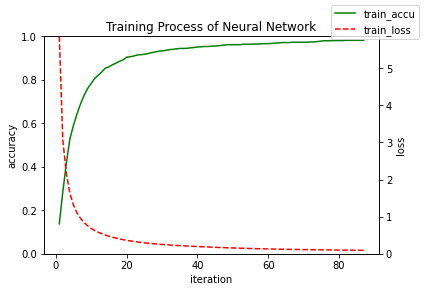

In [17]:
train_evaluate(model,history,X_test,y_test)

In [18]:
model = BPNeuralNetwork(hidden_layer_sizes=(100,),activation=relu(),tol=1e-8,max_iter=200)
history = model.train(X_train,y_train)

Total Iter: 23 / 200
Optimization beneath tol.


Model Structure:


,Layer Type,Size,Activation Function
0,inputLayer,64,identity
1,Layer,100,relu
2,outputLayer,10,softmax


Test Loss:	 1.19253
Test Accuracy:	 0.96111


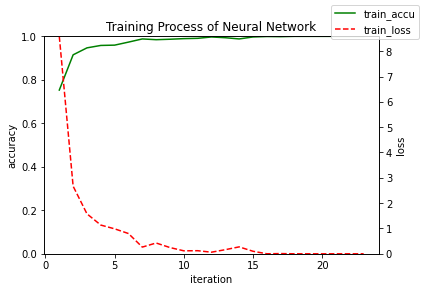

In [19]:
train_evaluate(model,history,X_test,y_test)

本轮对比可以看出，网络结构相同的情况下，使用`relu`作为激活函数往往能够使模型加速收敛，且最终表现较好；`sigmoid`函数因为导函数值较小，容易出现梯度消失的情况，所以不仅模型收敛速度较慢，而且也有可能因为多次梯度消失导致提前收敛，最终表现不是特别好。

In [20]:
model.predict(X_test[:10])

array([6, 2, 5, 3, 7, 8, 6, 2, 1, 3])

Total Iter: 76 / 200
Optimization beneath tol.
Model Structure:


,Layer Type,Size,Activation Function
0,inputLayer,64,identity
1,Layer,32,relu
2,outputLayer,10,softmax


Test Loss:	 1.01320
Test Accuracy:	 0.91944


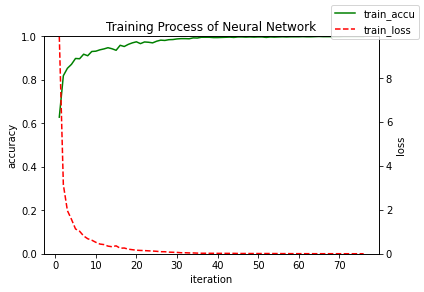

In [21]:
model = BPNeuralNetwork(hidden_layer_sizes=(32,),activation=relu(),tol=1e-8,max_iter=200)
history = model.train(X_train,y_train)

train_evaluate(model,history,X_test,y_test)

Total Iter: 145 / 200
Optimization beneath tol.
Model Structure:


,Layer Type,Size,Activation Function
0,inputLayer,64,identity
1,Layer,32,relu
2,Layer,16,relu
3,outputLayer,10,softmax


Test Loss:	 1.64716
Test Accuracy:	 0.38611


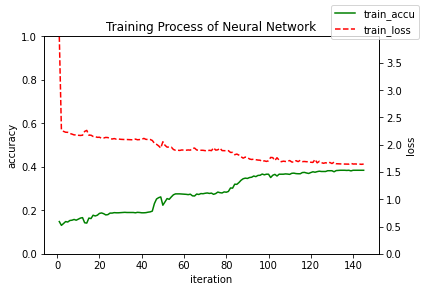

In [22]:
model = BPNeuralNetwork(hidden_layer_sizes=(32,16),activation=relu(),tol=1e-8,max_iter=200)
history = model.train(X_train,y_train)

train_evaluate(model,history,X_test,y_test)

In [23]:
model.layers[2].grad

array([-0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -2.53209703e-08, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00])

这一次实验隐藏层数增加，展现了`relu`函数的弱点，即**“死亡Relu”**。因为参数不恰当的更新（比如学习率设置的过大）导致出现负值，而relu函数、导函数在自变量为负值时均为0，会导致某一梯度变为0之后，永远无法更新，也就是这个隐层神经元“死亡”了。而同样的网络结构换用`sigmoid`作为激活函数并不会出现这样的问题。

Total Iter: 177 / 200
Optimization beneath tol.
Model Structure:


,Layer Type,Size,Activation Function
0,inputLayer,64,identity
1,Layer,32,sigmoid
2,Layer,16,sigmoid
3,outputLayer,10,softmax


Test Loss:	 0.48586
Test Accuracy:	 0.86944


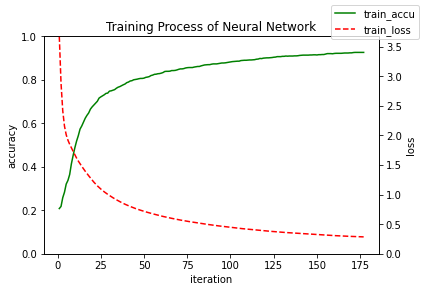

In [24]:
model = BPNeuralNetwork(hidden_layer_sizes=(32,16),activation=sigmoid(),tol=1e-8,max_iter=200)
history = model.train(X_train,y_train)

train_evaluate(model,history,X_test,y_test)

In [25]:
model.layers[2].grad

array([ 3.60639992e-03,  1.25682840e-04,  6.93461731e-03, -6.40269890e-04,
       -4.00750112e-02,  2.30742193e-02, -5.82608968e-02,  4.12186950e-06,
       -1.02405951e-03, -5.15133091e-04,  3.01855122e-04, -2.57302600e-03,
       -6.43587049e-04,  1.54500792e-02,  4.61627819e-02,  1.63981829e-02])

# 总结

1. 完成了实验的各项要求，通过使用sklearn的神经网络分类器和自己使用numpy实现神经网络分类器，增进了对前馈神经网络的理解，通过模型对手写数字数据集进行了分类，调优后的模型表现均尚可。
2. sklearn实验能够逐步理解参数，而复现神经网络感觉难度较大，大量的时间花费在对基本的神经网络正向传播和反向传播的理解中，自己也参考课本和网络上的一些资料，对于推导过程进行了推演和编程实现，通过广泛的学习和实验，对网络布局和激活函数的使用有了更加直观的理解。理论课程中虽说感觉把握了神经网络及其反向传播的基本思想，但是在复现的过程中还是感觉有些许困难，必须自己推演一遍才能掌握。另外，感觉自己对于numpy向量、矩阵运算不够熟练，导致完成时间较长。
3. 神经网络复现部分，参考对比了网络上的一些实现的文章，我实现的神经网络的优点主要在于：
    1. 能够自适应调整输入、输出层维度；
    2. 能够自定义添加多个隐层（很多实现只包含单个隐层），且有多个参数可调节，自定义程度更高；
    3. 网络、层、激活函数都使用了面向对象的思想，代码结构方面可能更清晰、易于理解。
    4. 能够展现网络结构，易于理解。
4. 本次实验的不足：
    1. 没有实现分批(batch)训练，整体训练速度一般。
    2. 虽然使用面向对象易于理解，但是代码整体较长，不如其他人的简洁凝练。
    3. 没有添加完备的异常处理，仅对神经网络进行了复现和基本实验，健壮性有待提升。